# CAPTCHA OCR Model\n
## Kaggle Adapted - С автоматической проверкой путей\n
\n
Этот ноутбук автоматически найдет пути к данным!

In [1]:

"""
CAPTCHA OCR Model - Adapted from Kaggle notebook
Версия для современного TensorFlow и локального запуска
"""

# ========================================
# КОНСТАНТЫ И НАСТРОЙКИ
# ========================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Путь к данным - ДЛЯ KAGGLE.COM
LABELS_FILE = "../input/russian-captcha-images-base64/labels.csv"
IMG_FOLDER = "../input/russian-captcha-images-base64/translit/images"

# Параметры обучения
EPOCHS = 15  # Увеличено для лучшей точности
BATCH_SIZE = 16
TEST_SIZE = 0.1
RANDOM_STATE = 42
EARLY_STOPPING_PATIENCE = 10

# Параметры датасета (для тестирования на малом объеме)
USE_FULL_DATASET = False  # True = полный датасет, False = только первые 1000
MAX_SAMPLES = 40000  # Если USE_FULL_DATASET=False

# Параметры модели
MAX_SEQUENCE_LENGTH = 7
IMG_WIDTH = 200
IMG_HEIGHT = 60
IMG_CHANNELS = 3

print("="*60)
print("КОНФИГУРАЦИЯ")
print("="*60)
print(f"EPOCHS: {EPOCHS}")
print(f"BATCH_SIZE: {BATCH_SIZE}")
print(f"USE_FULL_DATASET: {USE_FULL_DATASET}")
if not USE_FULL_DATASET:
    print(f"MAX_SAMPLES: {MAX_SAMPLES}")
print("="*60)

# ========================================
# БЛОК 1: Загрузка данных
# ========================================

2025-10-27 20:50:46.715153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761598246.982937      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761598247.057744      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


КОНФИГУРАЦИЯ
EPOCHS: 15
BATCH_SIZE: 16
USE_FULL_DATASET: False
MAX_SAMPLES: 40000


In [2]:
print("\n[БЛОК 1] Загрузка данных...")

df = pd.read_csv(LABELS_FILE, header=None, encoding='utf-8', delimiter=';', names=['text', 'filename'])
data = {row.text: row.filename for row in df.itertuples()}

print(f"Загружено {len(data)} записей")

# Ограничиваем для быстрого теста
if not USE_FULL_DATASET:
    items = list(data.items())[:MAX_SAMPLES]
    data = {k: v for k, v in items}
    print(f"Ограничено до {len(data)} записей для быстрого теста")

# ========================================
# БЛОК 2: Создание словаря символов
# ========================================


[БЛОК 1] Загрузка данных...
Загружено 39774 записей
Ограничено до 39774 записей для быстрого теста


In [3]:
print("\n[БЛОК 2] Создание словаря символов...")

characters = sorted(set(''.join(data.keys())))
char_to_num = {v: i for i, v in enumerate(characters)}
num_to_char = {str(i): v for i, v in enumerate(characters)}
num_to_char['-1'] = 'UKN'  # Для CTC декодирования

print(f"Алфавит ({len(characters)} символов): {characters}")

# ========================================
# БЛОК 3: Функция предобработки изображения
# ========================================


[БЛОК 2] Создание словаря символов...
Алфавит (20 символов): ['2', '4', '5', '6', '7', '8', '9', 'б', 'в', 'г', 'д', 'ж', 'к', 'л', 'м', 'н', 'п', 'р', 'с', 'т']


In [4]:
print("\n[БЛОК 3] Определение функций предобработки...")

def encode_single_sample(filename):
    """Загружает и предобрабатывает изображение"""
    img_path = os.path.join(IMG_FOLDER, filename)
    img = tf.io.read_file(img_path)
    
    try:
        img = tf.io.decode_png(img, channels=3)
    except Exception as e:
        print(f"Ошибка с файлом {img_path}: {e}")
        # Пробуем JPEG
        img = tf.io.decode_jpeg(img, channels=3)
    
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.transpose(img, perm=[1, 0, 2])  # (width, height, channels)
    
    return img.numpy()

print("Функции предобработки определены")

# ========================================
# БЛОК 4: Создание обучающего и валидационного датасетов
# ========================================


[БЛОК 3] Определение функций предобработки...
Функции предобработки определены


In [5]:
print("\n[БЛОК 4] Создание обучающих данных...")

def create_train_and_validation_datasets():
    X, y = [], []
    
    items = list(data.items())
    
    if USE_FULL_DATASET:
        # Полный датасет: первые 10000 + последние 10000
        if len(items) > 20000:
            train_dataset = items[:10000] + items[-10000:]
            test_dataset = items[10000:-10000]
        else:
            # Если мало данных, используем все
            train_dataset = items
            test_dataset = []
    else:
        # Быстрый тест на малой выборке
        train_dataset = items
        test_dataset = []
    
    y_texts, filenames = zip(*train_dataset)
    
    print(f"Кодируем {len(filenames)} изображений...")
    
    # Сначала создаем y_list, фильтруя невалидные данные
    y_list = []
    valid_filenames = []
    skipped = 0
    
    for label, filename in zip(y_texts, filenames):
        try:
            encoded = [char_to_num[c] for c in label]
            y_list.append(encoded)
            valid_filenames.append(filename)
        except KeyError as e:
            skipped += 1
            if skipped <= 3:  # Показываем первые 3 ошибки
                print(f"Предупреждение: пропускаем '{label}' из-за неизвестного символа")
    
    if skipped > 0:
        print(f"Всего пропущено: {skipped} записей с невалидными символами")
    
    # Теперь загружаем только валидные изображения
    X = np.asarray([encode_single_sample(fn) for fn in valid_filenames])
    
    # Применяем padding
    y = tf.keras.preprocessing.sequence.pad_sequences(y_list, MAX_SEQUENCE_LENGTH, padding='post', value=-1)
    
    print(f"Форма X: {X.shape}")
    print(f"Форма y: {y.shape}")
    
    # Разделение на train/val
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_STATE
    )
    
    return X_train, X_val, y_train, y_val, test_dataset

X_train, X_val, y_train, y_val, test_dataset = create_train_and_validation_datasets()

print(f"Разделение на train/val: X_train={X_train.shape}, X_val={X_val.shape}")

# ========================================
# БЛОК 5: Визуализация данных
# ========================================


[БЛОК 4] Создание обучающих данных...
Кодируем 39774 изображений...


2025-10-27 20:51:04.121828: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Форма X: (39774, 200, 60, 3)
Форма y: (39774, 7)
Разделение на train/val: X_train=(35796, 200, 60, 3), X_val=(3978, 200, 60, 3)



[БЛОК 5] Визуализация примеров...
Примеры сохранены в output/dataset_samples.png


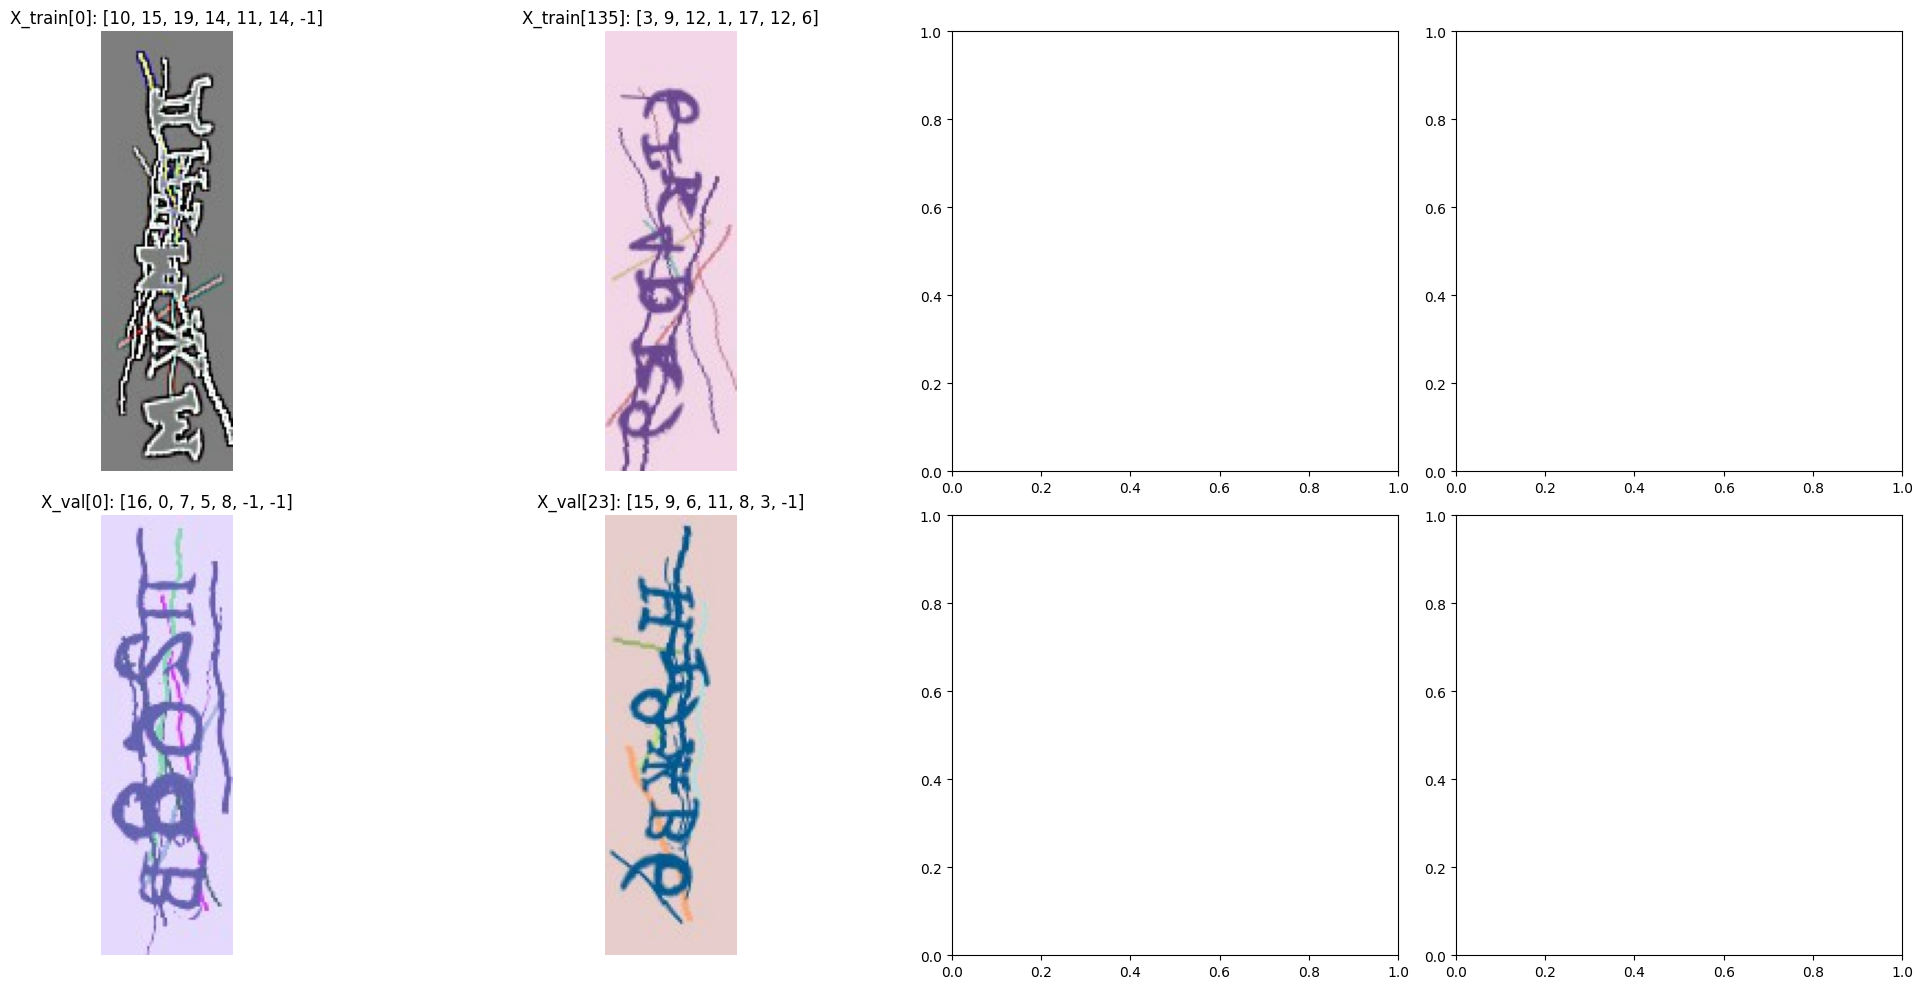

In [6]:
print("\n[БЛОК 5] Визуализация примеров...")

# Проверяем что данные загружены
if 'X_train' not in globals() or 'X_val' not in globals():
    print("❌ ОШИБКА: Данные не загружены!")
    print("Вы должны сначала запустить ячейки БЛОК 1-4 (cells 1-5)")
    print("Пожалуйста, запустите все предыдущие ячейки по порядку")
    raise NameError("X_train не определен. Запустите ячейки 1-5 перед этой ячейкой.")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes[0, 0].imshow(X_train[0], cmap='gray')
axes[0, 0].set_title(f'X_train[0]: {list(y_train[0])}')
axes[0, 0].axis('off')

axes[0, 1].imshow(X_train[min(135, len(X_train)-1)], cmap='gray')
axes[0, 1].set_title(f'X_train[135]: {list(y_train[min(135, len(y_train)-1)])}')
axes[0, 1].axis('off')

axes[1, 0].imshow(X_val[0], cmap='gray')
axes[1, 0].set_title(f'X_val[0]: {list(y_val[0])}')
axes[1, 0].axis('off')

axes[1, 1].imshow(X_val[min(23, len(X_val)-1)], cmap='gray')
axes[1, 1].set_title(f'X_val[23]: {list(y_val[min(23, len(y_val)-1)])}')
axes[1, 1].axis('off')

plt.tight_layout()
os.makedirs("output", exist_ok=True)
plt.savefig('output/dataset_samples.png')
print("Примеры сохранены в output/dataset_samples.png")

# ========================================
# БЛОК 6: Определение CTCLayer
# ========================================

In [7]:
print("\n[БЛОК 6] Определение CTCLayer...")

class CTCLayer(layers.Layer):
    """CTC Loss Layer для обучения"""
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        labels_mask = 1 - tf.cast(tf.equal(y_true, -1), dtype="int64")
        labels_length = tf.reduce_sum(labels_mask, axis=1)
        
        loss = self.loss_fn(y_true, y_pred, input_length, tf.expand_dims(labels_length, -1))
        self.add_loss(loss)
        
        return y_pred

print("CTCLayer определен")

# ========================================
# БЛОК 7: Построение модели
# ========================================


[БЛОК 6] Определение CTCLayer...
CTCLayer определен


In [8]:
print("\n[БЛОК 7] Построение модели...")

def build_model():
    """Создает OCR CNN-LSTM модель"""
    input_img = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), name="image", dtype="float32") 
    labels = layers.Input(name="label", shape=(MAX_SEQUENCE_LENGTH,), dtype="float32")

    # Первый conv блок
    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", 
                      padding="same", name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Второй conv блок
    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", 
                      padding="same", name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Reshape для RNN
    x = layers.Reshape(target_shape=(50, 960), name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNN слои
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # CTC layer
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Определяем модель
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_cnn_lstm_model")
    
    # Компилируем
    model.compile(optimizer=keras.optimizers.Adam())
    return model

model = build_model()
print("\nСводка модели:")
model.summary()

# ========================================
# БЛОК 8: Создание TensorFlow datasets
# ========================================


[БЛОК 7] Построение модели...

Сводка модели:


Model: "ocr_cnn_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 60,   │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 60,   │        896 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 30,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 30,   │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 15,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 960)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     61,504 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 64)    │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 256)   │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 50, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, 7)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 21)    │      2,709 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 21)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 445,589 (1.70 MB)

 Trainable params: 445,589 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
print("\n[БЛОК 8] Создание TensorFlow datasets...")

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(
    lambda x, y: {'image': x, 'label': y}
).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation_dataset = validation_dataset.map(
    lambda x, y: {'image': x, 'label': y}
).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

print("Datasets созданы")

# ========================================
# БЛОК 9: Обучение модели
# ========================================


[БЛОК 8] Создание TensorFlow datasets...
Datasets созданы


In [10]:
print("\n[БЛОК 9] Обучение модели...")

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=EARLY_STOPPING_PATIENCE, 
    restore_best_weights=True
)

print(f"Начинаем обучение на {EPOCHS} эпохах...")
history = model.fit(
    train_dataset, 
    validation_data=validation_dataset, 
    epochs=EPOCHS, 
    callbacks=[early_stopping],
    verbose=1
)

print("\nОбучение завершено!")

# ========================================
# БЛОК 10: Визуализация истории обучения
# ========================================


[БЛОК 9] Обучение модели...
Начинаем обучение на 15 эпохах...
Epoch 1/15
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 496s 211ms/step - loss: 297.0852 - val_loss: 51.3187
Epoch 2/15
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 469s 210ms/step - loss: 44.0187 - val_loss: 9.4824
Epoch 3/15
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 462s 206ms/step - loss: 15.1837 - val_loss: 6.1161
Epoch 4/15
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 460s 206ms/step - loss: 10.4487 - val_loss: 4.8614
Epoch 5/15
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 502s 205ms/step - loss: 8.3555 - val_loss: 4.4508
Epoch 6/15
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 458s 205ms/step - loss: 7.5138 - val_loss: 4.2536
Epoch 7/15
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 459s 205ms/step - loss: 6.5612 - val_loss: 3.9132
Epoch 8/15
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 459s 205ms/step - loss: 6.4703 - val_loss: 3.5537
Epoch 9/15
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 459s 205ms/step - loss: 5.6953 - val_loss: 3.2391
Epoch 10/15
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 502s 205ms/step - loss: 5.2928 - val_loss: 3.7634
Epoch 11/1


[БЛОК 10] Визуализация истории обучения...
График сохранен в output/training_history.png


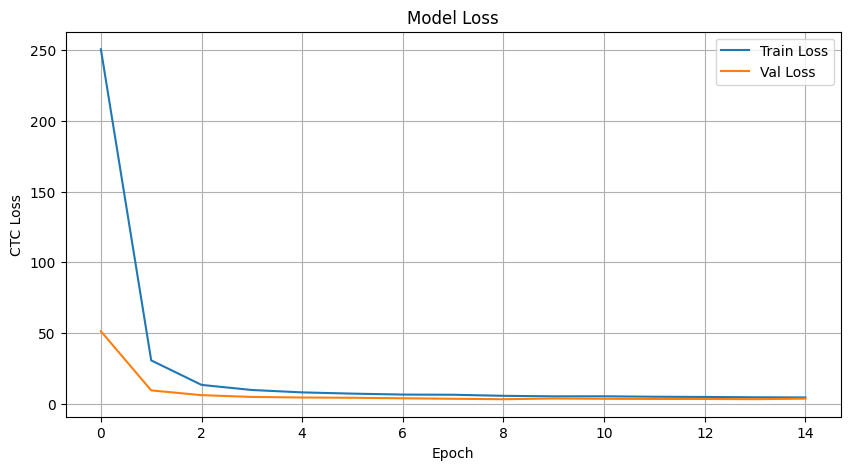

In [11]:
print("\n[БЛОК 10] Визуализация истории обучения...")

import os
os.makedirs("output", exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('CTC Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.savefig('output/training_history.png')
print("График сохранен в output/training_history.png")

# ========================================
# БЛОК 11: Создание prediction model
# ========================================

In [12]:
print("\n[БЛОК 11] Создание prediction model...")

prediction_model = keras.models.Model(
    model.inputs[0],  # Используем первый input модели
    model.get_layer(name="dense2").output
)

prediction_model.summary()

# ========================================
# БЛОК 12: Сохранение модели
# ========================================


[БЛОК 11] Создание prediction model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 60, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 60, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 30, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 30, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 960)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        61,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 21)         │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 445,589 (1.70 MB)

 Trainable params: 445,589 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
print("\n[БЛОК 12] Сохранение модели...")

# Создаем папку output если её нет
import os
os.makedirs("output", exist_ok=True)

# Сохранение в разных форматах
prediction_model.save("output/model.h5")
print("✓ Модель сохранена в output/model.h5")

prediction_model.save("output/model.keras")
print("✓ Модель сохранена в output/model.keras")

# Экспорт в SavedModel формат
try:
    prediction_model.export("output/model")
    print("✓ Модель экспортирована в output/model (SavedModel format)")
except Exception as e:
    print(f"⚠ Не удалось экспортировать в SavedModel: {e}")

# Экспорт в TFLite (для мобильных устройств)
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(prediction_model)
    tflite_model = converter.convert()
    with open("output/model.tflite", "wb") as f:
        f.write(tflite_model)
    print("✓ Модель экспортирована в output/model.tflite (TensorFlow Lite)")
except Exception as e:
    print(f"⚠ Не удалось экспортировать в TFLite: {e}")

print(f"\n{'='*60}")
print("Все модели сохранены в папку output/")
print(f"{'='*60}")

# ========================================
# БЛОК 13: Тестирование на валидационной выборке
# ========================================


[БЛОК 12] Сохранение модели...
✓ Модель сохранена в output/model.h5
✓ Модель сохранена в output/model.keras
Saved artifact at 'output/model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 60, 3), dtype=tf.float32, name='image')
Output Type:
  TensorSpec(shape=(None, 50, 21), dtype=tf.float32, name=None)
Captures:
  132642789650704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132642789648976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132641931336912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132641931337872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132641931338064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132641931336528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132641931339408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132641931340176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132641931341520: TensorSpec(shape=(), dtype=tf.resou

W0000 00:00:1761605849.784921      13 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1761605849.785077      13 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1761605849.817244      13 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
loc(callsite(callsite(fused["TensorListReserve:", "functional_1/bidirectional_1/backward_lstm_1/TensorArrayV2_1@__inference_function_647249"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_647356"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): error: 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
loc(callsite(callsite(fused["TensorListReserve:", "functional_1/bidirectional_1/backward_lstm_1/TensorArrayV2_1@__inference_function_647249"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_647356"]) at fused["StatefulParti

In [14]:
print("\n[БЛОК 13] Тестирование на валидационной выборке...")

y_pred = prediction_model.predict(X_val, verbose=1)
y_pred_decoded = keras.backend.ctc_decode(
    y_pred, 
    input_length=np.ones(X_val.shape[0]) * 50, 
    greedy=True
)[0][0][:, :MAX_SEQUENCE_LENGTH].numpy()

print("\nПримеры предсказаний:")
for i in range(min(10, len(y_val))):
    pred_chars = [num_to_char[str(x)] if x > -1 else '' for x in y_pred_decoded[i]]
    true_chars = [num_to_char[str(int(x))] if int(x) > -1 else '' for x in y_val[i]]
    
    pred_text = ''.join([c for c in pred_chars if c != 'UKN'])
    true_text = ''.join([c for c in true_chars if c != 'UKN'])
    
    match = "✓" if pred_text == true_text else "✗"
    print(f"{match} True: '{true_text}' | Pred: '{pred_text}'")

# ========================================
# БЛОК 14: Вычисление точности
# ========================================


[БЛОК 13] Тестирование на валидационной выборке...
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step

Примеры предсказаний:
✓ True: 'п2б8в' | Pred: 'п2б8в'
✓ True: '89гл' | Pred: '89гл'
✓ True: 'пб8ср' | Pred: 'пб8ср'
✓ True: '75т66п' | Pred: '75т66п'
✓ True: 'д8т4тн' | Pred: 'д8т4тн'
✓ True: 'ст56бб2' | Pred: 'ст56бб2'
✓ True: 'кд78л5' | Pred: 'кд78л5'
✓ True: 'птнм' | Pred: 'птнм'
✓ True: 'гд4мдбл' | Pred: 'гд4мдбл'
✓ True: 'вбмбкг6' | Pred: 'вбмбкг6'


In [15]:
print("\n[БЛОК 14] Вычисление точности...")

correct = 0
total = len(y_val)

for i in range(len(y_val)):
    pred_chars = [num_to_char[str(x)] if x > -1 else '' for x in y_pred_decoded[i]]
    true_chars = [num_to_char[str(int(x))] if int(x) > -1 else '' for x in y_val[i]]
    
    pred_text = ''.join([c for c in pred_chars if c not in ['UKN', '']])
    true_text = ''.join([c for c in true_chars if c not in ['UKN', '']])
    
    if pred_text == true_text:
        correct += 1

accuracy = correct / total * 100
print(f"\n{'='*60}")
print(f"ТОЧНОСТЬ: {accuracy:.2f}% ({correct}/{total})")
print(f"{'='*60}")

print("\nОбучение завершено успешно!")




[БЛОК 14] Вычисление точности...

ТОЧНОСТЬ: 95.60% (3803/3978)

Обучение завершено успешно!
